In [1]:
using ModelingToolkit, DifferentialEquations, Plots

In [2]:
function magicFormula(α; F_z=2000, γ=0)
    # For more information on the Magic Formula Tyre model, please refer to [ref: https://doi.org/10.4271/870421]
    a_1 = -22.1; a_2 = 1011; a_3 = 1078; a_4 = 1.82; a_5 = 0.208; a_6 = 0.000; 
    a_7 = -0.354; a_8 = 0.707; a_9 = 0.028; a_10 = 0.000; a_11 = 14.8; a_12 = 0.022

    # IMPORTANT conversions (forces in `kN` and angles in `deg`)
    α_d = rad2deg(α); γ_d = rad2deg(γ); F_zk = F_z / 1e3

    # Formula equations
    C = 1.3
    D = a_1 * F_zk ^ 2 + a_2 * F_zk
    B = a_3 * sin(a_4 * atan(a_5 * F_zk)) / (C * D) * (1 - a_12 * abs(γ_d))
    E = a_6 * F_zk ^ 2 + a_7 * F_zk + a_8
    # vertical and horizontal shifts due to camber
    ΔS_h = a_9 * γ_d
    ΔS_v = (a_10 * F_zk ^ 2 + a_11 * F_zk) * γ_d
    α_ΔS_h = α_d + ΔS_h
    ϕ = (1 - E) * α_ΔS_h + E / B * atan(B * α_ΔS_h)

    return D * sin(C * atan(B * ϕ)) + ΔS_v;
end;


# Magic Formula
Ξ(α) = magicFormula(α)
@register_symbolic Ξ(α)

function lateralModel(;δ, v_x)
    @variables t
    D = Differential(t)

    @mtkmodel BicycleModel begin
        @parameters begin
            m = 1555 # mass of the vehicle
            θ = 2491 # Inertia of the vehicle
            l_f = 1.354 # length from front tyre to c.g.
            l_r = 1.372 # length from rear tyre to c.g.
        end
        @variables begin
            p_x(t) 
            p_y(t)
            
            v_y(t)
            ψ(t)
            ψd(t)

            v_xft(t)
            v_yft(t)
            α_f(t)
            α_r(t)
        end
        @equations begin
            m * D(v_y) ~ -m * v_x(t) * D(ψ) + Ξ(α_f) * cos(δ(t)) + Ξ(α_r)

            D(ψ) ~ ψd
            θ * D(ψd) ~ l_f * Ξ(α_f) * cos(δ(t)) - l_r * Ξ(α_r)

            v_xft ~ v_x(t) * cos(δ(t)) + sin(δ(t)) * (v_y + l_f * ψd)
            v_yft ~ -v_x(t) * sin(δ(t)) + cos(δ(t)) * (v_y + l_f * ψd)
            α_f ~ -atan(v_yft, v_xft)
            α_r ~ -atan(v_y - l_r * ψd, v_x(t))

            # global positions
            D(p_x) ~ v_x(t) * cos(ψ) - v_y * sin(ψ)
            D(p_y) ~ v_y * cos(ψ) + v_x(t) * sin(ψ)
        end
    end

    @mtkbuild lateral = BicycleModel()

    return lateral
end;

In [3]:
model = lateralModel(δ = t -> deg2rad(10), v_x = t -> 10)

prob = ODEProblem(model, [model.p_x => 0, model.p_y => 0, model.v_y => 0, model.ψ => 0, model.ψd => 0], (0.0, 40.0))
sol = solve(prob);

In [19]:
sol(10)[4:5]

2-element Vector{Float64}:
 30.137651237576694
 71.90661813349793

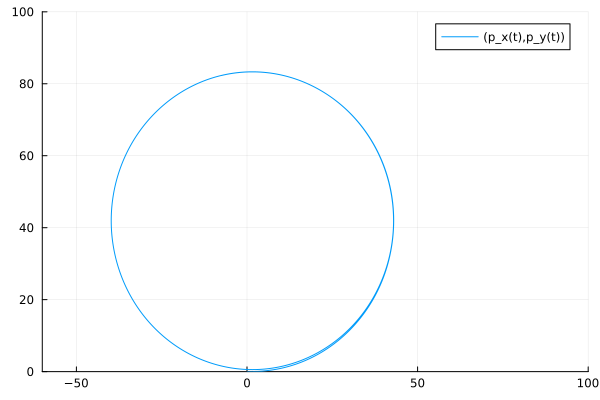

In [5]:
plot(sol, idxs = (4,5), xlims = (-60,100), ylims = (0,100))